In [1]:
import logging
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets as dset
from torchvision import models
from torchvision import transforms as transforms
from torchvision.utils import make_grid
from utils import *


In [2]:
# pick a model to test
MODEL = 'wideresnet'

In [3]:
# choose the seed
# manualSeed = np.random.randint(0, 1000)
if MODEL == 'wideresnet':
    manualSeed = 126
else: 
    manualSeed = 919


logging.info("manual seed in main file is {}".format(manualSeed))
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
print("Seed: {}".format(manualSeed))

Seed: 126


In [4]:
##
# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda:0")

CUDA Available:  True


In [5]:
if MODEL == "wideresnet":
    targeted_model = models.wide_resnet50_2(pretrained=True).to(device)
elif MODEL == "inception":
    targeted_model = models.inception_v3(pretrained=True).to(device)
elif MODEL == "vgg16":
    targeted_model = models.vgg16(pretrained=True)



In [6]:
# load the model to device
targeted_model = targeted_model.to(device)
targeted_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [7]:
# ImageNet Dataloader
if MODEL == "inception":
    image_transforms = transforms.Compose(
        [
            transforms.Resize(299),  # this is for Inception_V3
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )
else:
    image_transforms = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )




In [8]:
# load an image to verify the method

from PIL import Image
img_dir = './images'
img_files = []

entries = os.listdir(img_dir)
for file in entries:
    img_path = os.path.join(img_dir, file)
    img_files.append(img_path)
print(img_files)


['./images/ILSVRC2012_val_00013998.JPEG', './images/ILSVRC2012_val_00034250.JPEG', './images/ILSVRC2012_val_00003816.JPEG', './images/ILSVRC2012_val_00035833.JPEG']


In [9]:
batch_t = []
for file in img_files:
    img_t = image_transforms(Image.open(file))
    batch_t.append(img_t)
batch_t = torch.stack(batch_t).to(device)

In [10]:
batch_t.shape

torch.Size([4, 3, 224, 224])

In [11]:
out = targeted_model(batch_t)
print(out.shape)

torch.Size([4, 1000])


In [12]:
_, indices = torch.max(out, 1)
indices

tensor([11, 11, 11, 11], device='cuda:0')

In [13]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
def unnormalize_vis(x):
    x_ = x.clone().detach()
    dtype = x_.dtype
    mean = torch.as_tensor(MEAN, dtype=dtype, device=x_.device)
    std = torch.as_tensor(STD, dtype=dtype, device=x_.device)
    # tensor.sub_(mean[:, None, None]).div_(std[:, None, None])
    x_.mul_(std[:, None, None]).add_(mean[:, None, None])
    return x_

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



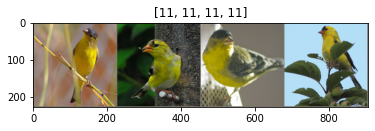

In [14]:
vis = make_grid(batch_t)
imshow(vis.cpu(), title=[x.item() for x in indices])



In [15]:
artifact1 = torch.load('./artifacts/vgg16-custardapple.pt')
artifact2 = torch.load('./artifacts/inception-artichoke.pt')
artifact3 = torch.load('./artifacts/wideresnet-pineapple.pt')
artifact4 = torch.load('./artifacts/wideresnet-conch.pt')


In [16]:
# load the TnT artifacts
if MODEL == 'inception':
    UAP = artifact2
elif MODEL == 'wideresnet':
    UAP_1 = artifact3
    UAP = artifact4
elif MODEL == "vgg16":
    UAP = artifact1

In [17]:
at, _ = blend_test(batch_t, UAP, MODEL)

In [18]:
out_at = targeted_model(at.to(device))

In [19]:
_, indices_at = torch.max(out_at, 1)
# classes[index]
indices_at

tensor([112, 112, 112, 112], device='cuda:0')

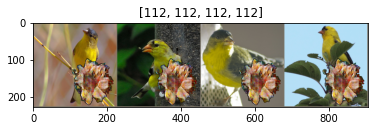

In [20]:
vis_at = make_grid(at)
# imshow(vis_at.cpu().detach(), title=[classes[x] for x in indices_at])
imshow(vis_at.cpu().detach(), title=[x.item() for x in indices_at])